In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.signal.windows import gaussian

In [2]:
data_dir = 'E:/Data Science/UROP/data/'

In [3]:
def line_plot(x_data: np.array = None, 
              y_data: np.array = None,
              title: str = None,
              xlabel: str = None,
              ylabel: str = None,
              line_width: float = 0.5,
              color = "red",
              line_style = "-",
              ):

    plt.plot(x_data, y_data, 
             linewidth=line_width,
             color=color,
             linestyle=line_style)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return None

def heatmap_plot(matrix, cmap='viridis'):
    plt.imshow(matrix, cmap=cmap)
    plt.colorbar()
    plt.show()

# Loading raw .npy files

In [4]:
# Loading data
B500HZ = np.load(f'{data_dir}0605_breathing_500HZ.npy')
o_moves = np.load(f'{data_dir}0605_other_moves.npy')
breathing = np.load(f'{data_dir}0610_breathing.npy')
walking = np.load(f'{data_dir}0610_walking.npy')
np_walking = np.load(f'{data_dir}0613_nonpure_walking.npy')
std_breathing = np.load(f'{data_dir}0613_standing_breathing.npy')
walk_and_breathe = np.load(f'{data_dir}0613_walking_and_breathing.npy')

# Loading complex number data

In [5]:
# x-y plot of real and imaginary components
complex_data = [np.real(B500HZ[:,0]), 
                np.imag(B500HZ[:,0]),
                np.real(o_moves[:,0]),
                np.imag(o_moves[:,0]),
                np.real(breathing[:,0]),
                np.imag(breathing[:,0]),
                np.real(np_walking[:, 0]),
                np.imag(np_walking[:, 0]),
                np.real(std_breathing[:, 0]),
                np.imag(std_breathing[:, 0]),
                np.real(walk_and_breathe[:, 0]),
                np.imag(walk_and_breathe[:, 0])
                ]

complex_data_labels = ['Breathing (500HZ)',
                       'Other moves',
                       'Breathing',
                       'Walking',
                       'Standing and breathing',
                       'Walking and breathing'
                       ]

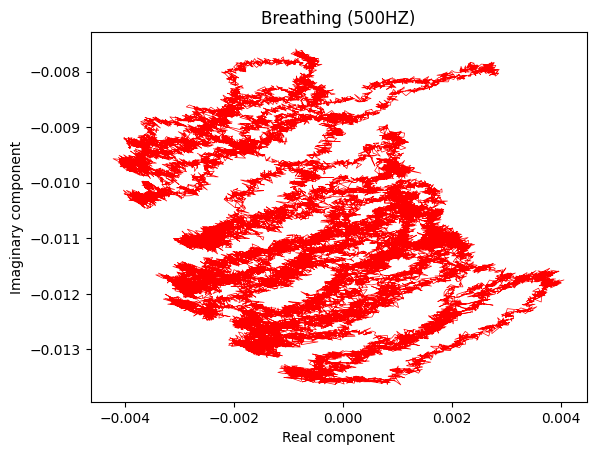

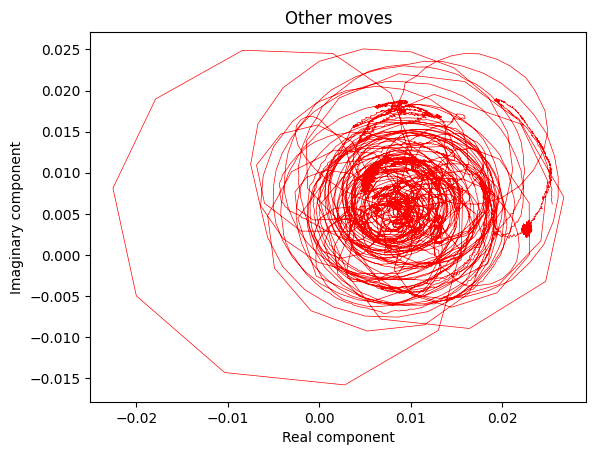

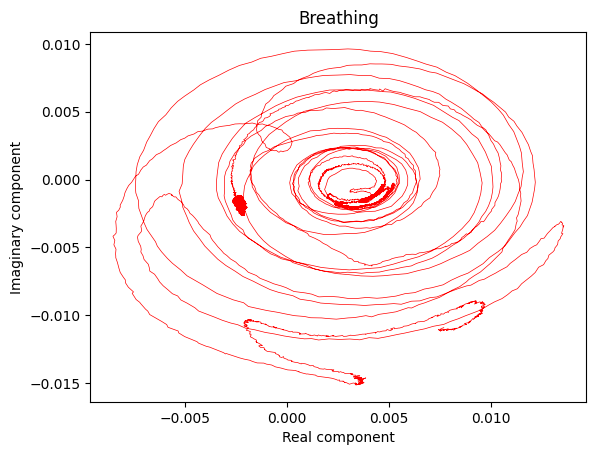

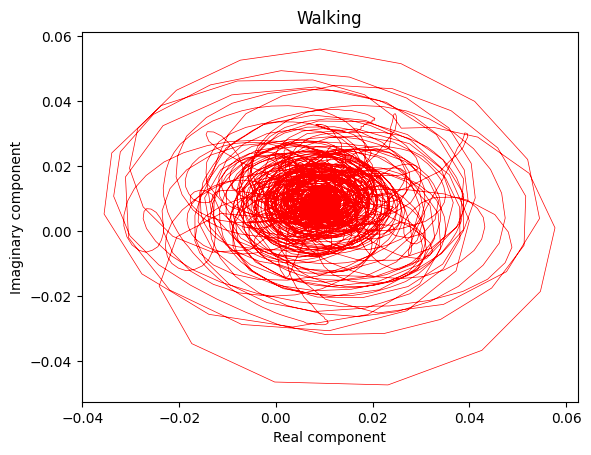

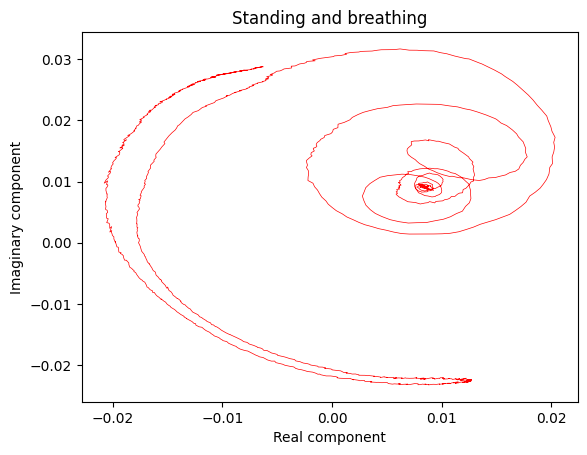

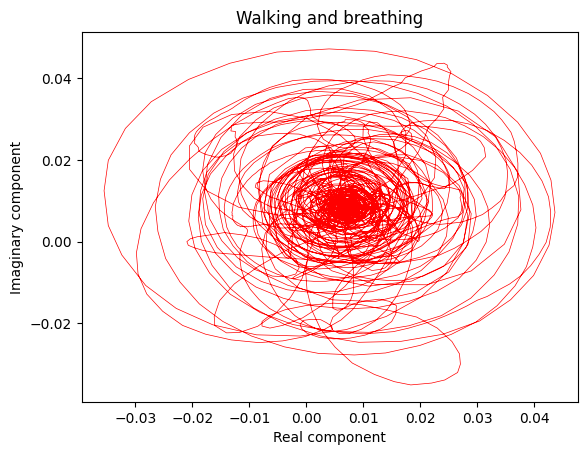

In [6]:
xlabel = 'Real component'
ylabel = 'Imaginary component'

for i in range(0, len(complex_data), 2):
    line_plot(complex_data[i], 
              complex_data[i+1],
              title=complex_data_labels[i//2],
              xlabel=xlabel,
              ylabel=ylabel)
    

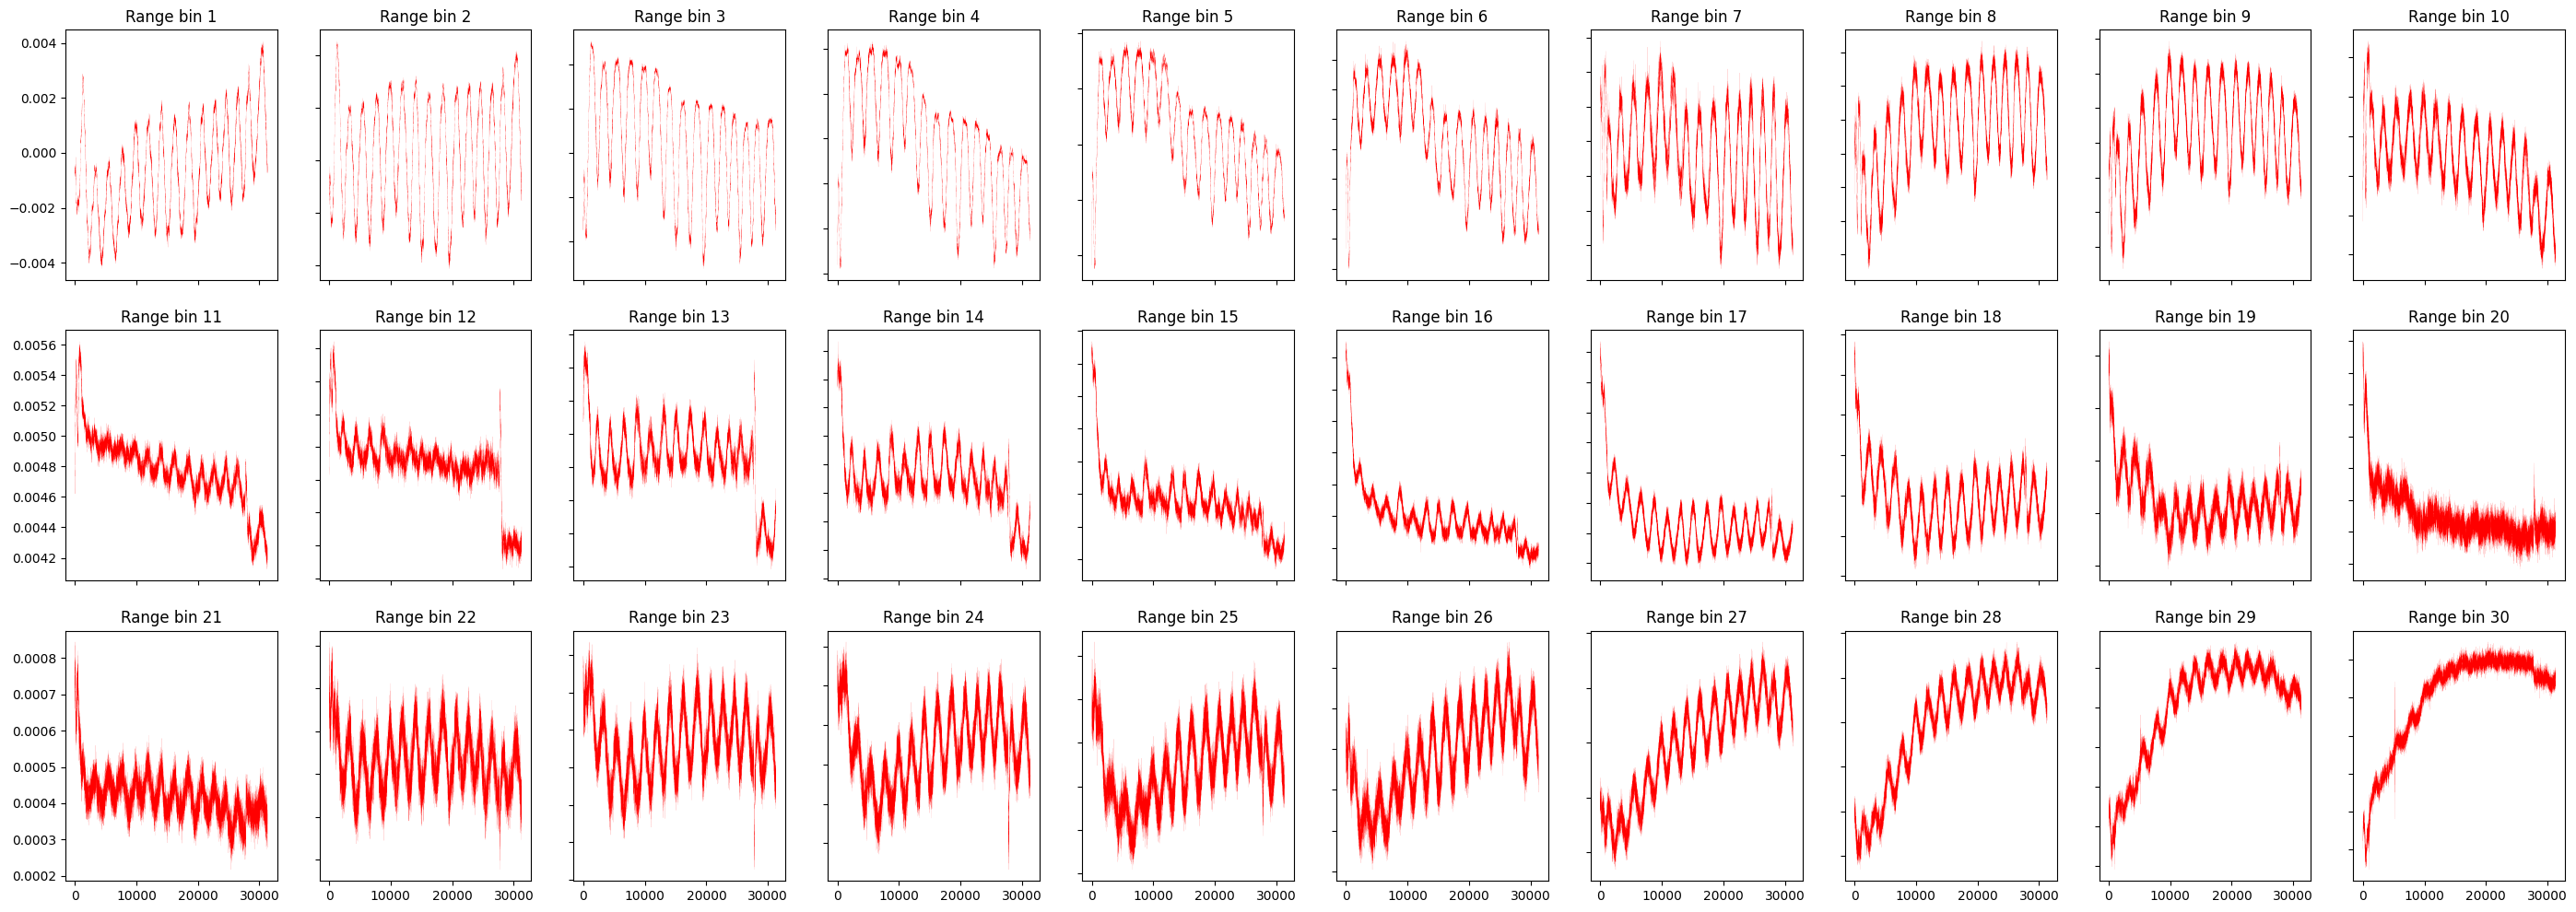

In [7]:
# Visualising the evolution of a large set of range bins
x9 = np.linspace(0, np.size(B500HZ, 0)-1, np.size(B500HZ, 0))

sub_rows = 3
fig, ax = plt.subplots(sub_rows, 
                       10,
                       figsize=(35, 12))


for row in range(sub_rows):
    for column in range(10):
        ax[row, column].plot(x9, np.real(B500HZ[:, int(str(row) + str(column))]),
                            color="red",
                            linewidth=0.05,
                            linestyle="-")
        temp = int(str(row) + str(column)) + 1
        ax[row, column].set_title(f'Range bin {temp}')

for ax in ax.flat:
    ax.label_outer()

    

In [ ]:
# Investigating further range bins with a running window (5 - 10 seconds)
bin_number = 35  # arbitrary range bin

# using a short time Fourier transform
T_x, N = 1 / 500, 31301  # 500 HZ sampling rate for a 62.602 s signal
t_x = np.arange(N) * T_x  # time indices for signal
bin_values = np.real(B500HZ[:, bin_number])  # the signal

g_std = 64 # standard deviation for Gaussian window in samples
w = gaussian(256, std=g_std, sym=True)  # symmetric Gaussian window (may try something else); 3-second window
SFT = signal.ShortTimeFFT(w, hop=10, fs=1/T_x, mfft=4096, scale_to='magnitude')
Sx = SFT.stft(bin_values)

# plotting
x10 = np.linspace(0, np.size(Sx, 0)-1, np.size(Sx, 0))

fig2, axs2 = plt.subplots(1, 2, figsize=(16,6))

axs2[0].plot(x9, bin_values, linewidth=0.05, color="red")
axs2[0].set_title(f'Range bin {bin_number}')

axs2[1].plot(x10[160:], Sx[160:], linewidth=0.05, color="green")
axs2[1].set_title(f'Short-time Fourier Transform of range bin {bin_number}')

In [ ]:
# Dissecting the SFFT further, discarding the first discard_index values
discard_index = 130  # discarding the 0.5-0.6m range which is dominated by noise
x11 = np.linspace(discard_index, np.size(Sx, 0)-1, np.size(Sx, 0)-discard_index)
rows = 24
columns = 5
fig3, ax3 = plt.subplots(rows, columns, figsize=(35, 56))
starting_bin = 250
for row in range(rows):
    for column in range(columns):
        ax3[row, column].plot(x11, Sx[discard_index:, starting_bin])
        starting_bin += 1
        ax3[row, column].set_title(f'STFT: Range bin {starting_bin}')

for ax in ax3.flat:
    ax.label_outer()


In [ ]:
# Applying a 4th-order Butterworth high-pass filter
bin_number_hpf = 37
hpf = signal.butter(4,  3, btype='highpass', output='sos', fs=500)
sig = np.real(B500HZ[:, bin_number_hpf])

B_hpf = signal.sosfilt(hpf, sig)
x111 = np.linspace(0, np.size(B_hpf, 0), np.size(B_hpf, 0))

plt.plot(x111[10:, ], B_hpf[10:], linewidth=0.15)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f"High-pass filter: bin {bin_number_hpf}")
plt.show()


In [ ]:
# Running high pass filters on a set of range bins
n = 20  # arbitrary starting bin
rows_2 = 12
columns_2 = 4
fig6, ax6 = plt.subplots(rows_2, columns_2, figsize=(35, 56))

# high-pass filter column by column and apply imshow to the entire matrix
for row in range(rows_2):
    for column in range(columns_2):
        sig = np.real(B500HZ[:, n])
        B_hpf = signal.sosfilt(hpf, sig)
        # cutting off the samples close to the radar
        ax6[row, column].plot(x111[60:,], B_hpf[60:,], linewidth=0.15)
        n +=1
        ax6[row, column].set_title(f'HPF: Range bin {n}')

for ax in ax6.flat:
    ax.label_outer()

In [144]:
# Iterating through with a HPF
matrix = np.real(B500HZ)
for column in range(0, matrix.shape[1]):
    matrix[:, column] = signal.sosfilt(hpf,  matrix[:, column])


for i in range(3000, 30000, 99):
    heatmap_plot(matrix[3000+i-99:3000+i, 10:109])







KeyboardInterrupt: 